# Install packages

In [ ]:
# Install your required packages here
!pip install --user pandas numpy matplotlib sklearn 
import os
import time

start = time.time()

You should consider upgrading via the '/home/andy/anaconda3/bin/python -m pip install --upgrade pip' command.


In [ ]:
# # Mount google drive
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import gzip
import json
from tqdm import tqdm
import os
from collections import Counter
from datetime import datetime
import math
tqdm.pandas() #for progres_apply etc.

In [ ]:
#read file line-by-line and parse json, returns dataframe
# read_max = -1 to read full dataset
def parse_json(filename_gzipped_python_json, read_max=-1):
  #read gzipped content
  f=gzip.open(filename_gzipped_python_json,'r')
  
  #parse json
  parse_data = []
  for line in tqdm(f): #tqdm is for showing progress bar, always good when processing large amounts of data
    line = line.decode('utf-8')
    line = line.replace('true','True') #difference json/python
    line = line.replace('false','False')
    parsed_result = eval(line) #load python nested datastructure
    parse_data.append(parsed_result)
    if read_max !=-1 and len(parse_data) > read_max:
      print(f'Break reading after {read_max} records')
      break
  print(f"Reading {len(parse_data)} rows.")

  #create dataframe
  df= pd.DataFrame.from_dict(parse_data)
  return df


# 1. Load Goodreads data

In [ ]:
# goodreads_path = './content/AI Project/datasets/Goodreads/'
goodreads_path = '/home/andy/Desktop/AI_Project/datasets/Goodreads/'
books = 'goodreads_books_comics_graphic.json.gz'
interactions = 'goodreads_interactions_comics_graphic.json.gz'
reviews = 'goodreads_reviews_comics_graphic.json.gz'

# 2. Clean data
Example of:
- Merging two files
- tqdm pd.progress_apply
- Example of non-destructive transforms, i.e. keep original data and make re-running cell works
- Parsing dates

In [ ]:
#books
books_df = pd.read_json(goodreads_path + books, lines=True)
books_df = books_df[['book_id',	'title','authors',	'publisher',	'num_pages',	'publication_year']]
display(books_df.head(5))

,book_id,title,authors,publisher,num_pages,publication_year
0,25742454,The Switchblade Mamma,"[{'author_id': '8551671', 'role': ''}]",,,
1,30128855,Cruelle,"[{'author_id': '3274315', 'role': ''}]",Dargaud,,2016
2,13571772,Captain America: Winter Soldier (The Ultimate ...,"[{'author_id': '37450', 'role': ''}]",Hachette Partworks Ltd.,146,2012
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...,"[{'author_id': '16209952', 'role': ''}, {'auth...",,,
4,707611,"Superman Archives, Vol. 2","[{'author_id': '81563', 'role': ''}, {'author_...",DC Comics,272,1997


In [ ]:
#get author names (authors metadata is an additional dowload from goodreads)
authors = '/metadata/' + 'goodreads_book_authors.json.gz'
authors_df =  pd.read_json(goodreads_path + authors, lines=True) #829.529 authors (also non-graphic and comics)
display(authors_df.head(5))

,average_rating,author_id,text_reviews_count,name,ratings_count
0,3.98,604031,7,Ronald J. Fields,49
1,4.08,626222,28716,Anita Diamant,546796
2,3.92,10333,5075,Barbara Hambly,122118
3,3.68,9212,36262,Jennifer Weiner,888522
4,3.82,149918,96,Nigel Pennick,1740


In [ ]:
#merge, but inline for each row, since each book has many authors
author_id_to_name = {}
for idx, row in tqdm(authors_df.iterrows(), total=authors_df.shape[0]):
  author_id_to_name[row['author_id']] = row['name']
display(books_df.head(5))
#important: type of author is np.int64
books_df['author_name'] = books_df['authors'].apply(lambda authors_dct_lst: author_id_to_name.get(np.int64(authors_dct_lst[0]['author_id'])))
display(books_df.head(5))

100%|██████████| 829529/829529 [01:14<00:00, 11154.65it/s]


,book_id,title,authors,publisher,num_pages,publication_year
0,25742454,The Switchblade Mamma,"[{'author_id': '8551671', 'role': ''}]",,,
1,30128855,Cruelle,"[{'author_id': '3274315', 'role': ''}]",Dargaud,,2016
2,13571772,Captain America: Winter Soldier (The Ultimate ...,"[{'author_id': '37450', 'role': ''}]",Hachette Partworks Ltd.,146,2012
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...,"[{'author_id': '16209952', 'role': ''}, {'auth...",,,
4,707611,"Superman Archives, Vol. 2","[{'author_id': '81563', 'role': ''}, {'author_...",DC Comics,272,1997


,book_id,title,authors,publisher,num_pages,publication_year,author_name
0,25742454,The Switchblade Mamma,"[{'author_id': '8551671', 'role': ''}]",,,,Lindsey Schussman
1,30128855,Cruelle,"[{'author_id': '3274315', 'role': ''}]",Dargaud,,2016,Florence Dupre la Tour
2,13571772,Captain America: Winter Soldier (The Ultimate ...,"[{'author_id': '37450', 'role': ''}]",Hachette Partworks Ltd.,146,2012,Ed Brubaker
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...,"[{'author_id': '16209952', 'role': ''}, {'auth...",,,,Jason Delgado
4,707611,"Superman Archives, Vol. 2","[{'author_id': '81563', 'role': ''}, {'author_...",DC Comics,272,1997,Jerry Siegel


In [ ]:
#sample first 2.000.000 interactions
interactions_df = parse_json(goodreads_path + interactions, read_max=2000000) #Note: RAM issue if loading with pd.read_json, no issue with parse_json 

2000000it [01:26, 23085.78it/s]


Break reading after 2000000 records
Reading 2000001 rows.


In [ ]:
#1) parse date 
interactions_df_new = interactions_df[['user_id', 'book_id', 'rating', 'date_updated']]
format_str = '%a %b %d %H:%M:%S %z %Y' #see https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior
#test: datetime_object = datetime.strptime('Fri Jun 21 10:25:05 -0700 2013', format_str) 
interactions_df_new['date_updated'] = interactions_df_new['date_updated'].progress_apply(lambda s: np.datetime64(datetime.strptime(s,format_str)))

#2) sort on user_id, then date
interactions_df_new = interactions_df_new.sort_values(by=['user_id', 'date_updated'], ascending=[True,True])
display(interactions_df_new.head(20))

  0%|          | 0/2000001 [00:00<?, ?it/s]<ipython-input-11-21b3a43ee86b>:5: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  interactions_df_new['date_updated'] = interactions_df_new['date_updated'].progress_apply(lambda s: np.datetime64(datetime.strptime(s,format_str)))
100%|██████████| 2000001/2000001 [01:05<00:00, 30492.91it/s]
<ipython-input-11-21b3a43ee86b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  interactions_df_new['date_updated'] = interactions_df_new['date_updated'].progress_apply(lambda s: np.datetime64(datetime.strptime(s,format_str)))


,user_id,book_id,rating,date_updated
1651325,00004584d524ec468619e81b176cc991,271199,4,2013-06-21 17:23:44
1651324,00004584d524ec468619e81b176cc991,287380,4,2013-06-21 17:24:05
1651322,00004584d524ec468619e81b176cc991,287381,4,2013-06-21 17:24:31
1651316,00004584d524ec468619e81b176cc991,287382,4,2013-06-21 17:25:05
1651314,00004584d524ec468619e81b176cc991,287388,3,2013-06-21 17:25:13
1651312,00004584d524ec468619e81b176cc991,287385,4,2013-06-21 17:25:29
1651311,00004584d524ec468619e81b176cc991,287383,4,2013-06-21 17:25:37
1651308,00004584d524ec468619e81b176cc991,287364,5,2013-06-21 17:26:36
1651307,00004584d524ec468619e81b176cc991,287368,4,2013-06-21 17:26:43
1651306,00004584d524ec468619e81b176cc991,287371,4,2013-06-21 17:26:52


#3. Create consecutive ID's
- Working with numpy types != python types
- Mapping ID's to consecutive integgers for matrix operations (and scipy sparse matrices, see https://docs.scipy.org/doc/scipy/reference/sparse.html) 

In [ ]:
#change type book_id to numpy.int64
display(interactions_df_new.dtypes)
interactions_df_new['book_id'] = interactions_df_new['book_id'].astype('int64')
display(interactions_df_new.dtypes)

user_id                 object
book_id                 object
rating                   int64
date_updated    datetime64[ns]
dtype: object

user_id                 object
book_id                  int64
rating                   int64
date_updated    datetime64[ns]
dtype: object

In [ ]:
#1) convert user uuid to consecutive integer ID's 
dct = {}
def map_to_consecutive_id(uuid):
  if uuid in dct:
    return dct[uuid]
  else:
    id = len(dct)
    dct[uuid] = id
    return id
interactions_df_new['user_id_int'] = interactions_df_new['user_id'].progress_apply(map_to_consecutive_id)

#2) convert book_id to to consecutive integer ID's 
dct.clear()
books_df['book_id_int'] = books_df['book_id'].progress_apply(map_to_consecutive_id)
interactions_df_new['book_id_int'] = interactions_df_new['book_id'].progress_apply(lambda book_id: dct.get(book_id,-1))
display(books_df.head(10))
display(interactions_df_new.head(10))


100%|██████████| 2000001/2000001 [00:04<00:00, 403388.65it/s]


,book_id,title,authors,publisher,num_pages,publication_year,author_name,book_id_int
0,25742454,The Switchblade Mamma,"[{'author_id': '8551671', 'role': ''}]",,,,Lindsey Schussman,0
1,30128855,Cruelle,"[{'author_id': '3274315', 'role': ''}]",Dargaud,,2016,Florence Dupre la Tour,1
2,13571772,Captain America: Winter Soldier (The Ultimate ...,"[{'author_id': '37450', 'role': ''}]",Hachette Partworks Ltd.,146,2012,Ed Brubaker,2
3,35452242,Bounty Hunter 4/3: My Life in Combat from Mari...,"[{'author_id': '16209952', 'role': ''}, {'auth...",,,,Jason Delgado,3
4,707611,"Superman Archives, Vol. 2","[{'author_id': '81563', 'role': ''}, {'author_...",DC Comics,272,1997,Jerry Siegel,4
5,2250580,"A.I. Revolution, Vol. 1","[{'author_id': '1015982', 'role': ''}]",Go! Comi,206,2007,Yuu Asami,5
6,27036536,"War Stories, Volume 3","[{'author_id': '14965', 'role': ''}, {'author_...",Avatar Press,224,2016,Garth Ennis,6
7,27036537,"Crossed, Volume 15","[{'author_id': '24594', 'role': ''}]",Avatar Press,160,2016,Mike Wolfer,7
8,27036538,"Crossed + One Hundred, Volume 2 (Crossed +100 #2)","[{'author_id': '14155472', 'role': ''}, {'auth...",Avatar Press,160,2016,Simon Spurrier,8
9,27036539,"War Stories, Volume 4","[{'author_id': '14965', 'role': ''}, {'author_...",Avatar Press,144,2016,Garth Ennis,9


,user_id,book_id,rating,date_updated,user_id_int,book_id_int
1651325,00004584d524ec468619e81b176cc991,271199,4,2013-06-21 17:23:44,0,28265
1651324,00004584d524ec468619e81b176cc991,287380,4,2013-06-21 17:24:05,0,66852
1651322,00004584d524ec468619e81b176cc991,287381,4,2013-06-21 17:24:31,0,75982
1651316,00004584d524ec468619e81b176cc991,287382,4,2013-06-21 17:25:05,0,66850
1651314,00004584d524ec468619e81b176cc991,287388,3,2013-06-21 17:25:13,0,44061
1651312,00004584d524ec468619e81b176cc991,287385,4,2013-06-21 17:25:29,0,37059
1651311,00004584d524ec468619e81b176cc991,287383,4,2013-06-21 17:25:37,0,66851
1651308,00004584d524ec468619e81b176cc991,287364,5,2013-06-21 17:26:36,0,15835
1651307,00004584d524ec468619e81b176cc991,287368,4,2013-06-21 17:26:43,0,15834
1651306,00004584d524ec468619e81b176cc991,287371,4,2013-06-21 17:26:52,0,1593


# 4. Pre-process interactions
- Drop reconsumption items
- Remove items with fewer than x interactions
- Remove users with fewer than x interactions

In [ ]:
def preprocess_classic(df, minsup=5):
    """
    Goal: - Remove reconsumption items
          - Remove items that have less than minsup interactions 
          - Remove users that have less than minsup interactions 
               
    :input df: Dataframe containing user_id, item_id and time
    """
    before = df.shape[0]
    #drop reconsumption items
    df = df.drop_duplicates(subset=["user_id","item_id"])
    print("After drop_duplicates (reconsumption items): {} -> {}".format(before,df.shape[0]))
    #compute item/user counts
    g1 = df.groupby('item_id', as_index=False)['user_id'].size()
    g1 = g1.rename({'size': 'count_item'}, axis='columns')
    g2 = df.groupby('user_id', as_index=False)['item_id'].size()
    g2 = g2.rename({'size': 'count_user'}, axis='columns')
    df = pd.merge(df, g1, how='left', on=['item_id'])
    df = pd.merge(df, g2, how='left', on=['user_id'])
    display(df.head(5))
    #drop items occurring less than minsup times
    before = df.shape[0]
    df = df[df['count_item'] >= minsup]
    print("After dropping items with less than {} interactions: {} -> {}".format(minsup, before,df.shape[0]))
    before = df.shape[0]
    #drop users with less then minsup items in history
    #changed minsup to minsup/2 so more users remain which is positive for the algorithm
    df = df[df['count_user'] >= minsup/2]
    df = df[['user_id','item_id','datetime']]
    print("After dropping users with less than {} interactions: {} -> {}".format(minsup, before,df.shape[0]))
    return df

#Remark: ignoring rating, considering all reviews as implicit possitive feedback
#print number of users and items
interactions_df_processed = interactions_df_new[['user_id_int','book_id_int','date_updated']]
interactions_df_processed = interactions_df_processed.rename(columns={"user_id_int": "user_id", "book_id_int": "item_id", "date_updated": "datetime"})
print(f"number of unique users: {interactions_df_processed['user_id'].nunique()}")
print(f"number of unique items: {interactions_df_processed['item_id'].nunique()}")
interactions_df_processed = preprocess_classic(interactions_df_processed,20)
display(interactions_df_processed.head(5))
print(f"number of unique users: {interactions_df_processed['user_id'].nunique()}")
print(f"number of unique items: {interactions_df_processed['item_id'].nunique()}")

#make our own mapping of user_id and item_id to consecutive numbers
user_dic={}
counter=0
for i in interactions_df_processed['user_id'].unique():
  user_dic[i]=counter
  counter+=1

item_dic={}
counter=0
for i in interactions_df_processed['item_id'].unique():
  item_dic[i]=counter
  counter+=1
print(interactions_df_processed.head(10))
interactions_df_processed["user_id"]=interactions_df_processed["user_id"].apply(lambda x: user_dic[x])
interactions_df_processed["item_id"]=interactions_df_processed["item_id"].apply(lambda x: item_dic[x])

number of unique users: 73352
number of unique items: 77205
After drop_duplicates (reconsumption items): 2000001 -> 2000001


,user_id,item_id,datetime,count_item,count_user
0,0,28265,2013-06-21 17:23:44,2485,24
1,0,66852,2013-06-21 17:24:05,434,24
2,0,75982,2013-06-21 17:24:31,53,24
3,0,66850,2013-06-21 17:25:05,69,24
4,0,44061,2013-06-21 17:25:13,72,24


After dropping items with less than 20 interactions: 2000001 -> 1686955
After dropping users with less than 20 interactions: 1686955 -> 1561680


,user_id,item_id,datetime
0,0,28265,2013-06-21 17:23:44
1,0,66852,2013-06-21 17:24:05
2,0,75982,2013-06-21 17:24:31
3,0,66850,2013-06-21 17:25:05
4,0,44061,2013-06-21 17:25:13


number of unique users: 25601
number of unique items: 16315
   user_id  item_id            datetime
0        0    28265 2013-06-21 17:23:44
1        0    66852 2013-06-21 17:24:05
2        0    75982 2013-06-21 17:24:31
3        0    66850 2013-06-21 17:25:05
4        0    44061 2013-06-21 17:25:13
5        0    37059 2013-06-21 17:25:29
6        0    66851 2013-06-21 17:25:37
7        0    15835 2013-06-21 17:26:36
8        0    15834 2013-06-21 17:26:43
9        0     1593 2013-06-21 17:26:52


# 5. Create train/test split
Different options:
- **Time-based split**, i.e. split interactions before/after certain date. Keep all users with both training and test interactions for evaluations. Repeat for different train/test window, i.e. repeat for a number of key dates.
- **Session-based split**, i.e. split and keep first $x$ interactions for training and $|I_u| - x$  for testing, where $I_u = {i_1,\ldots,i_k}$ represents the user's history sorted on time
- **Random**, i.e. take $x$ random items for training and $|I_u| -x$ for testing
- **Leave-one-out**, i.e. take last (or random) item for testing

Additionaly, use techniques such as cross-validation and create multiple train/test splits and report both average and standard deviation. 

In [ ]:
#Session-based split:
sessions_df = interactions_df_processed.groupby(by='user_id', as_index=False)[['item_id','datetime']].agg(list)
display(sessions_df.head(10))

def split(items, percentage_train):
  no_train_items = math.floor(len(items) * percentage_train)
  return items[0:no_train_items], items[no_train_items:]

percentage_train = 0.8
sessions_df['history'] = sessions_df['item_id'].apply(lambda items: split(items, percentage_train)[0])
sessions_df['future'] = sessions_df['item_id'].apply(lambda items: split(items, percentage_train)[1])
pd.set_option("display.max_colwidth", None)
display(sessions_df.head(10))
end = time.time()
print("time to read and preprocess data= {}".format(end - start))

,user_id,item_id,datetime
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[2013-06-21 17:23:44, 2013-06-21 17:24:05, 201..."
1,1,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 3...","[2012-10-21 16:23:19, 2012-10-21 16:27:04, 201..."
2,2,"[42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 5...","[2013-03-09 15:02:48, 2013-03-09 15:03:42, 201..."
3,3,"[66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 7...","[2008-12-21 00:48:01, 2008-12-21 02:52:51, 200..."
4,4,"[96, 97, 98, 99, 100, 101, 102, 103, 104, 105,...","[2012-12-21 01:34:22, 2012-12-21 01:34:25, 201..."
5,5,"[113, 114, 115, 116, 117, 118, 119, 120, 121, ...","[2012-10-01 11:08:19, 2013-01-21 15:35:04, 201..."
6,6,"[119, 136, 137, 151, 152, 153, 154, 155, 156, ...","[2012-08-05 16:26:00, 2012-08-05 20:11:48, 201..."
7,7,"[119, 154, 25, 24, 164, 165, 166, 67, 167, 168...","[2013-06-25 00:22:00, 2013-06-25 00:22:02, 201..."
8,8,"[206, 207, 208, 209, 210, 211, 212, 70, 213, 2...","[2013-03-21 08:48:25, 2013-03-24 03:08:58, 201..."
9,9,"[203, 216, 217, 218, 219, 220, 221, 222, 223, ...","[2009-11-29 01:29:05, 2009-11-29 01:31:04, 200..."


,user_id,item_id,datetime,history,future
0,0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]","[2013-06-21 17:23:44, 2013-06-21 17:24:05, 2013-06-21 17:24:31, 2013-06-21 17:25:05, 2013-06-21 17:25:13, 2013-06-21 17:25:29, 2013-06-21 17:25:37, 2013-06-21 17:26:36, 2013-06-21 17:26:43, 2013-06-21 17:26:52, 2013-06-21 17:28:02, 2013-06-21 17:28:14, 2013-06-21 17:28:35, 2013-06-21 17:28:49, 2013-06-21 17:28:59, 2013-06-21 17:29:04, 2013-06-21 17:29:12, 2013-06-21 17:29:19, 2013-06-21 17:29:23, 2013-06-21 17:29:31, 2013-06-21 17:29:42, 2013-06-21 17:30:43, 2013-06-21 17:30:51, 2013-06-21 17:30:56]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]","[19, 20, 21, 22, 23]"
1,1,"[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]","[2012-10-21 16:23:19, 2012-10-21 16:27:04, 2012-11-04 04:44:53, 2013-11-12 03:06:12, 2014-12-31 21:29:27, 2014-12-31 21:37:08, 2015-05-21 23:10:24, 2015-12-05 20:06:34, 2016-07-06 20:56:32, 2016-09-26 17:40:15, 2017-01-28 17:56:08, 2017-08-08 21:00:02, 2017-08-10 20:09:38, 2017-08-31 17:01:55, 2017-08-31 17:01:59, 2017-10-17 18:14:25, 2017-10-18 19:48:11, 2017-10-22 17:06:41]","[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37]","[38, 39, 40, 41]"
2,2,"[42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]","[2013-03-09 15:02:48, 2013-03-09 15:03:42, 2013-03-09 15:05:26, 2013-03-12 15:04:19, 2013-03-12 15:07:49, 2014-01-26 18:16:17, 2014-01-26 18:19:19, 2014-01-26 18:21:25, 2014-01-26 18:23:37, 2014-07-28 18:43:32, 2014-07-28 18:46:06, 2014-07-28 18:51:25, 2014-07-28 18:57:17, 2014-07-28 18:58:45, 2014-07-28 19:00:47, 2014-07-31 20:04:19, 2014-07-31 20:45:46, 2014-07-31 21:23:04, 2014-09-16 17:16:05, 2014-09-16 17:20:05, 2014-09-16 17:22:18, 2014-09-16 17:23:00, 2014-09-16 17:28:30, 2016-03-24 04:58:10]","[42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]","[61, 62, 63, 64, 65]"
3,3,"[66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 29, 93, 94, 95]","[2008-12-21 00:48:01, 2008-12-21 02:52:51, 2008-12-21 02:53:08, 2009-01-26 21:16:32, 2009-05-29 22:59:04, 2009-07-10 19:14:26, 2009-10-04 21:27:32, 2009-11-01 21:07:37, 2009-12-22 13:20:22, 2010-02-09 13:08:25, 2010-06-14 03:15:59, 2010-06-15 00:38:22, 2010-06-15 01:50:00, 2010-06-17 11:51:43, 2010-06-17 20:37:21, 2010-06-17 20:37:45, 2010-07-22 10:22:07, 2010-09-17 15:09:43, 2010-11-08 12:26:19, 2011-02-26 22:49:01, 2011-08-25 11:56:02, 2011-09-17 03:30:00, 2011-11-28 12:49:51, 2011-12-11 23:06:50, 2012-04-06 03:04:04, 2012-06-13 18:35:15, 2012-06-14 13:11:45, 2012-06-14 18:43:52, 2012-09-27 00:16:06, 2014-08-05 22:20:20, 2017-01-12 14:04:12]","[66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89]","[90, 91, 92, 29, 93, 94, 95]"
4,4,"[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 25]","[2012-12-21 01:34:22, 2012-12-21 01:34:25, 2012-12-21 01:34:27, 2012-12-21 01:34:30, 2012-12-21 01:34:38, 2012-12-21 01:34:42, 2012-12-21 01:34:54, 2012-12-21 01:34:59, 2012-12-21 01:44:44, 2012-12-21 02:16:46, 2012-12-21 02:16:48, 2012-12-21 02:17:04, 2012-12-21 02:17:46, 2012-12-30 04:52:50, 2012-12-30 04:54:50, 2012-12-30 04:54:59, 2012-12-30 16:48:42, 2012-12-30 18:38:47]","[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]","[110, 111, 112, 25]"
5,5,"[113, 114, 115, 116, 117, 118, 119, 120, 121, 71, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150]","[2012-10-01 11:08:19, 2013-01-21 15:35:04, 2013-04-24 18:21:30, 2013-04-24 18:21:42, 2013-04-24 18:22:36, 2013-06-11 18:52:59, 2013-06-11 18:53:26, 2013-06-11 18:53:37, 2013-06-11 18:53:52, 2013-06-11 18:54:36, 2013-06-11 18:54:46, 2013-06-11 18:54:47, 2013-06-11 18:55:08, 2013-06-11 18:55:34, 2013-06-11 18:56:57, 2013-06-11 18:59:01,

time to read and preprocess data= 333.3611719608307


# 6. Evaluate quantitatively
Options are:
- **Hitrate@k**, i.e. percentage of users where top-$k$ recommendations is relevant 
- **Recall@k**, i.e. percentage of top-$k$ recommendation that are relevant
- **NDCG@k**, i.e. like recall but rank of top-$k$ recommendation is weighted

Compare using relative gain, i.e. recall@10 from 10% tot 20% is a 100% gain (20-10/10 * 100) 

In [ ]:
import scipy.sparse
start2 = time.time()

#Create scipy csr matrix
def create_sparse_matrix(sessions_df, column='history', shape=None):
  #flatten
  user_ids = []
  item_ids = []
  for idx, row in sessions_df.iterrows():
    items = row[column]
    user = row['user_id']
    user_ids.extend([user] * len(items))
    item_ids.extend(items)
  #create csr matrix
  values = np.ones(len(user_ids))
  print(user_ids[:20])
  print(item_ids[:20])
  matrix = scipy.sparse.csr_matrix((values, (user_ids, item_ids)), shape=shape, dtype=np.int32)
  return matrix


shape = (interactions_df_processed['user_id'].max() +1,  interactions_df_processed['item_id'].max() +1)
print(shape)
train_x = create_sparse_matrix(sessions_df, column='history', shape=shape)
y_true = create_sparse_matrix(sessions_df, column='future', shape=shape)
# print(train_x)

(25601, 16315)
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 24]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3]
[19, 20, 21, 22, 23, 38, 39, 40, 41, 61, 62, 63, 64, 65, 90, 91, 92, 29, 93, 94]


In [ ]:
#popularity recommender
class Popularity():
    def __init__(self, K=10):
        self.K = K

    def fit(self, X):
        items = list(X.nonzero()[1])
        # print("begin")
        # print(X.nonzero())
        # print("end x[:5]")
        sorted_scores = Counter(items).most_common()
        self.sorted_scores_ = [
            (item, score / sorted_scores[0][1]) for item, score in sorted_scores
        ]

    def predict(self, X):
        items, values = zip(*self.sorted_scores_[: self.K])

        users = set(X.nonzero()[0])

        U, I, V = [], [], []

        for user in users:
            U.extend([user] * self.K)
            I.extend(items)
            V.extend(values)

        score_matrix = scipy.sparse.csr_matrix((V, (U, I)), shape=X.shape)
        return score_matrix



Produce Recall and NDGC @ 10,20,50,100 for comparing to the popularity recommender of the paper


In [ ]:
#Evaluate recall@k
#Do elementwise multiplication of top K predicts and true interactions
def sparse_divide_nonzero(a: scipy.sparse.csr_matrix, b: scipy.sparse.csr_matrix) -> scipy.sparse.csr_matrix:
    return a.multiply(sparse_inverse_nonzero(b))

def sparse_inverse_nonzero(a: scipy.sparse.csr_matrix) -> scipy.sparse.csr_matrix:
    inv_a = a.copy()
    inv_a.data = 1 / inv_a.data
    return inv_a

K = 10
print("Popularity:")
for K in [10,20,50,100]:
  pop = Popularity(K=K)
  pop.fit(train_x)
  y_pred = pop.predict(train_x)
  scores = scipy.sparse.lil_matrix(y_pred.shape)
  scores[y_pred.multiply(y_true).astype(bool)] = 1
  scores = scores.tocsr()
  scores = sparse_divide_nonzero(scores, scipy.sparse.csr_matrix(y_true.sum(axis=1))).sum(axis=1)
  print("recall @ {}: {:.4f}".format(K, scores.mean()))
  import sklearn.metrics
  ndcg = sklearn.metrics.ndcg_score(y_true.toarray(), y_pred.toarray(), k=K)
  print("ndcg @ {}: {:.4f}".format(K, ndcg))

Popularity:
recall @ 10: 0.0345
ndcg @ 10: 0.0331
recall @ 20: 0.0555
ndcg @ 20: 0.0405
recall @ 50: 0.1068
ndcg @ 50: 0.0579
recall @ 100: 0.1636
ndcg @ 100: 0.0743


Implement EASE

In [ ]:
#Embarrassingly Shallow Autoencoder
from scipy.sparse import find
class Ease():
    def __init__(self, K=10, l=200):
        self.K = K
        self.l = l
        self.B = None
        self.sessions_df=sessions_df

    def fit(self, X):
        G = X.transpose() * X
      
        diag=scipy.sparse.dia_matrix(G.shape)
        diag.setdiag([self.l]*G.shape[0])
        
        G = (G + diag).toarray()
        del diag
      
        P=np.linalg.inv(G)

        B=-P/P.diagonal()
        np.fill_diagonal(B,0)
        self.B=B
        

    def predict(self, X):
       

        S = X*self.B
        users = set(X.nonzero()[0])

        U, I, V = [], [], []

        for user in users:
            history_of_user=sessions_df.loc[sessions_df['user_id']==user].history.item()
            U.extend([user] * self.K)
            a=np.array([S[user][i] if i not in history_of_user else -self.l*2  for i in range(len(S[user])) ])
            items = a.argsort()[-self.K:][::-1]
            I.extend(items)
            V.extend(S[user][items])

        score_matrix = scipy.sparse.csr_matrix((V, (U, I)), shape=X.shape)
        return score_matrix



Produce Recall and NDCG @ 10,20,50,100 to compare to EASE from the paper

In [ ]:
#Evaluate recall@k
#Do elementwise multiplication of top K predicts and true interactions
def sparse_divide_nonzero(a: scipy.sparse.csr_matrix, b: scipy.sparse.csr_matrix) -> scipy.sparse.csr_matrix:
    return a.multiply(sparse_inverse_nonzero(b))

def sparse_inverse_nonzero(a: scipy.sparse.csr_matrix) -> scipy.sparse.csr_matrix:
    inv_a = a.copy()
    inv_a.data = 1 / inv_a.data
    return inv_a

K = 10
for K in [10,20,50,100]:
  ease = Ease(K=K)
  ease.fit(train_x.tocsc())
  y_pred = ease.predict(train_x)

  scores = scipy.sparse.lil_matrix(y_pred.shape)
  scores[y_pred.multiply(y_true).astype(np.bool)] = 1
  scores = scores.tocsr()
  scores = sparse_divide_nonzero(scores, scipy.sparse.csr_matrix(y_true.sum(axis=1))).sum(axis=1)
  print("recall @ {}: {:.4f}".format(K, scores.mean()))
  import sklearn.metrics
  ndcg = sklearn.metrics.ndcg_score(y_true.toarray(), y_pred.toarray(), k=K)
  print("ndcg @ {}: {:.4f}".format(K, ndcg))


<ipython-input-37-3f88ea4c78a2>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores[y_pred.multiply(y_true).astype(np.bool)] = 1


recall @ 10: 0.1934
ndcg @ 10: 0.2055


<ipython-input-37-3f88ea4c78a2>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores[y_pred.multiply(y_true).astype(np.bool)] = 1


recall @ 20: 0.2604
ndcg @ 20: 0.2247


<ipython-input-37-3f88ea4c78a2>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores[y_pred.multiply(y_true).astype(np.bool)] = 1


recall @ 50: 0.3619
ndcg @ 50: 0.2568


<ipython-input-37-3f88ea4c78a2>:18: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  scores[y_pred.multiply(y_true).astype(np.bool)] = 1


recall @ 100: 0.4412
ndcg @ 100: 0.2811


# 7. Evaluate qualitatively
Options are:
- **By example**, i.e. show history and recommendations for user, including item metadata and (if possible) an explanation (i.e., because you watched $i_x$ we recommend $i_y$)
- **Plot**, i.e. show plot that summarises recommendations, such as classic plots (i.e. distribution of popular items recommendations, recall versus user session length etc.) 
- **Advanced plots**, i.e. network visualisation or **sankey-diagram** ( https://plotly.com/python/sankey-diagram/)
- **Transparent surrogate model**, i.e. summarise recommender with a decision tree-model fitted on top of the recommendations, i.e. $\%x$ of recommendations are items viewed more than 10 times, $\%y$ of recommendations are viewed more than 10 times and in category $c_1$, etc.

The paper has a graph that shows the frequency of recommendations for items, we try to reproduce this with our dataset

In [ ]:
a=y_pred.getrow(0).toarray()
from scipy.sparse import find
print(books_df.head())
print()
print(train_x)
recommendations={}
counter=0
# iterate over all items and check how many times each id gets recommended
for user_id in range(y_pred.shape[0]):
  listofuser=[]
  predlist=find(y_pred[user_id])[1]
  for i in predlist:
    if i in recommendations:
      recommendations[i]+=1
    else:
      recommendations[i]=1
    if i in listofuser:
      counter+=1


    book_id  \
0  25742454   
1  30128855   
2  13571772   
3  35452242   
4    707611   

                                                                                             title  \
0                                                                            The Switchblade Mamma   
1                                                                                          Cruelle   
2  Captain America: Winter Soldier (The Ultimate Graphic Novels Collection: Publication Order, #7)   
3                          Bounty Hunter 4/3: My Life in Combat from Marine Scout Sniper to MARSOC   
4                                                                        Superman Archives, Vol. 2   

                                                                               authors  \
0                                               [{'author_id': '8551671', 'role': ''}]   
1                                               [{'author_id': '3274315', 'role': ''}]   
2                         

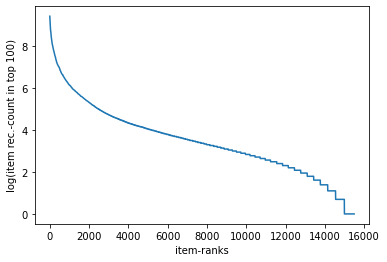

In [ ]:
x=list(reversed(sorted(recommendations.items(), key=lambda x: x[1])))
y=[math.log(e[1]) for e in x]
names=[e[0] for e in x]
import matplotlib.pyplot as plt
plt.plot(y)
plt.ylabel('log(item rec.-count in top 100)')
plt.xlabel('item-ranks')
plt.show()

In [ ]:
pop = Popularity(K=10)
#print top 10 most popular items
pop.fit(train_x)
y_pred = pop.predict(train_x)
popularity_top20=find(y_pred[0])[1]
for i in popularity_top20:
  real_id=(list(item_dic.keys())[i])
  title=books_df.loc[books_df['book_id_int'] == real_id].title.item()
  print(title)

Persepolis: The Story of a Childhood (Persepolis, #1)
Blankets
V for Vendetta
Watchmen
Preludes & Nocturnes (The Sandman #1)
Maus I: A Survivor's Tale: My Father Bleeds History (Maus, #1)
Fables, Vol. 1: Legends in Exile
Saga, Vol. 1 (Saga, #1)
Y: The Last Man, Vol. 1: Unmanned
The Walking Dead, Vol. 01: Days Gone Bye


This codeblock lets you manually check whether recommendations make sense, by providing you with the history future and predicted items.

If a predicted item matches the future it will be followed by a user hit user user_id

In [ ]:
ease = Ease(K=10)
ease.fit(train_x.tocsc())
y_pred = ease.predict(train_x)


a=y_pred.getrow(0).toarray()
from scipy.sparse import find

# print history future and recommendations for the first 50 users
for user_id in range(0,50):
  listofhis=[]
  listofuser=[]
  history_of_user=sessions_df.loc[sessions_df['user_id']==user_id].history.item()
  print("\n\nuser :{} history books".format(user_id))

  for book in history_of_user:
    real_id=(list(item_dic.keys())[book])

    title=books_df.loc[books_df['book_id_int'] == real_id].title.item()
    author=books_df.loc[books_df['book_id_int'] == real_id].author_name.item()
    publisher=books_df.loc[books_df['book_id_int'] == real_id].publisher.item()
    listofhis.append(title)

    print("title: {} author:{} publisher: {}".format(title,author,publisher))

  print("\n\nuser :{} future books".format(user_id))
  for i in find(y_true[user_id])[1]:
    real_id=(list(item_dic.keys())[i])
    title=books_df.loc[books_df['book_id_int'] == real_id].title.item()
    author=books_df.loc[books_df['book_id_int'] == real_id].author_name.item()
    publisher=books_df.loc[books_df['book_id_int'] == real_id].publisher.item()
    

    print("title: {} author:{} publisher: {}".format(title,author,publisher))
    listofuser.append(title)
  print("\n \nuser :{} predicted books".format(user_id))

  # print the predicted books
  for i in find(y_pred[user_id])[1]:
    real_id=(list(item_dic.keys())[i])
    title=books_df.loc[books_df['book_id_int'] == real_id].title.item()

    author=books_df.loc[books_df['book_id_int'] == real_id].author_name.item()
    publisher=books_df.loc[books_df['book_id_int'] == real_id].publisher.item()

    print("title: {} author:{} publisher: {}".format(title,author,publisher))
    if title in listofuser:
      print("         user hit found user {}".format(user_id))
    if title in listofhis:
      print("                   historyhit found his of user {}".format(user_id))
  print("\n\n")

    book_id  \
0  25742454   
1  30128855   
2  13571772   
3  35452242   
4    707611   

                                                                                             title  \
0                                                                            The Switchblade Mamma   
1                                                                                          Cruelle   
2  Captain America: Winter Soldier (The Ultimate Graphic Novels Collection: Publication Order, #7)   
3                          Bounty Hunter 4/3: My Life in Combat from Marine Scout Sniper to MARSOC   
4                                                                        Superman Archives, Vol. 2   

                                                                               authors  \
0                                               [{'author_id': '8551671', 'role': ''}]   
1                                               [{'author_id': '3274315', 'role': ''}]   
2                         